In [52]:
%pip install qiskit qiskit_aer pylatexenc

Note: you may need to restart the kernel to use updated packages.


In [133]:
import numpy as np
from qiskit import QuantumCircuit, transpile, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_circuit_layout, circuit_drawer
from qiskit_aer import AerSimulator, Aer
from qiskit.result import Counts
import matplotlib.pyplot as plt
import random

# Erdös InstitueMini Project #3
## Noah Lanier - $5$-qubit code under random Pauli error 
---
Task: Write a Qiskit function that takes the following inputs:

1. a boolean, $x\in \mathbb{F}_2$
2. an error probability $p$.
   
The ouput of the function is a quantum circuit that prepares (not necessarily fault tolerantly) the logical state,$|x_L\rangle$, for the $5$-qubit code, runs it through a random Pauli error channel, with error rate $p$ (for each qubit), measures syndromes, applies the recovery operations (if needed), and measures the data qubits. The success probabilty, is the probabilty that you measure a component of $|x_L\rangle$ at the end. Visualize the dependence of the success probability for various values of $p$.
***

First let's look at a circuit that prepares the logical state $|x_L\rangle$ for the $5$-qubit code and runs it through a random Pauli error channel with error rate $p$ (for each qubit.)

In [115]:
def prepare_5qubit_logical_state(x: bool, p: float) -> QuantumCircuit:
    """
    Prepares the logical state |x_L> encoded using the 5-qubit code, then applies
    random single-qubit Pauli errors (X, Y, Z) to each qubit with probability p.

    Args:
        x (bool): Logical bit value to encode (0 or 1).
        p (float): Error probability per qubit.

    Returns:
        QuantumCircuit: Circuit with encoded logical state and noise.
    """
    # Create a 5-qubit quantum circuit
    qc = QuantumCircuit(5)

    # Apply the encoding circuit for the 5-qubit code
    # Based on the standard encoding for |0_L⟩
    # See https://arxiv.org/abs/quant-ph/9602019 for original encoding
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.cx(0, 3)
    qc.cx(0, 4)
    
    qc.barrier()
    
    qc.h(1)
    qc.h(2)
    qc.h(3)
    qc.h(4)

    qc.barrier()

    qc.cz(0, 1)
    qc.cz(0, 2)
    qc.cz(0, 3)
    qc.cz(0, 4)

    qc.barrier()

    # If x == 1, apply a logical X (which is X on all qubits for the 5-qubit code)
    if x:
        for qubit in range(5):
            qc.x(qubit)

    # Apply random Pauli error with probability p to each qubit
    for qubit in range(5):
        if random.random() < p:
            error = random.choice(['x', 'y', 'z'])
            if error == 'x':
                qc.x(qubit)
            elif error == 'y':
                qc.y(qubit)
            elif error == 'z':
                qc.z(qubit)

    qc.name = f"5qubit_logical_{int(x)}_with_noise"
    return qc


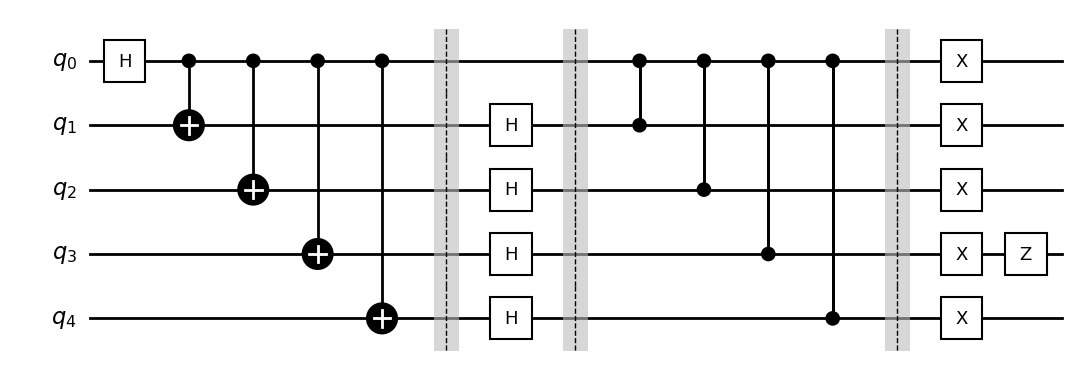

In [117]:
# Create logical |1_L⟩ with 10% error probability
qc = prepare_5qubit_logical_state(True, 0.1)
qc.draw('mpl',style="bw")

Next, we want to measure the syndrome of the logical qubit $|x_L\rangle$ using the four stabilizers that generate the stabilizer group of the $5$-qubit code. These generators are given by (where the tensor products are omitted):
\\[\begin{align*}
g_1&=\,X Z Z  X  I\\
g_2&=\,I X Z  Z  X\\
g_3&=\,X I X  Z  Z\\
g_4&=\,Z X I  X  Z.\\
\end{align*}\\]
Then, if necessary, we will apply the recovery operations and measure the data qubits. An example of how we decode syndromes can be shown for $X_0$, or, in other words, the case where there is an $X$ error on the $0$th qubit. The operator that represents this error is given by $XIIII$ and then we ask which stabilizers commute with this operator. We can see that $[g_i,XIIII]=0$ for $i=0,1,2,3$ and $[g_4,XIII]\neq 0$ thus our syndrome for $X_0$ is $0001$.

Finally, we plot the success probability of the code against the error probability per qubit $p$.

***Note***: This code runs $200$ simulations which make take a couple minutes to run.

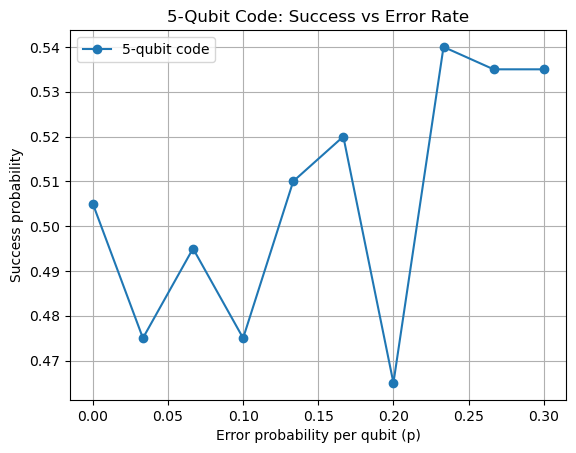

In [119]:
# Define stabilizers for 5-qubit code
stabilizers = [
    ['X', 'Z', 'Z', 'X', 'I'],
    ['I', 'X', 'Z', 'Z', 'X'],
    ['X', 'I', 'X', 'Z', 'Z'],
    ['Z', 'X', 'I', 'X', 'Z']
]

# Syndrome measurement circuits
def measure_syndromes(qc, data, ancillas):
    for i, stab in enumerate(stabilizers):
        for j, op in enumerate(stab):
            if op == 'I':
                continue
            elif op == 'X':
                qc.h(ancillas[i])
                qc.cx(ancillas[i], data[j])
                qc.h(ancillas[i])
            elif op == 'Z':
                qc.cz(ancillas[i], data[j])
        qc.measure(ancillas[i], i)
    return qc

# Decoder: handles all single-qubit X, Y and Z errors
# Returns (qubit_index, 'X'|'Y'|'Z') or None   (None -> "no correction needed")
def decode_syndrome(syndrome: str):
    corrections = {
        '0000': None,                         # ideal – no error detected

        # qubit-0 errors
        '0001': (0, 'X'),
        '1011': (0, 'Y'),
        '1010': (0, 'Z'),

        # qubit-1 errors
        '1000': (1, 'X'),
        '1101': (1, 'Y'),
        '0101': (1, 'Z'),

        # qubit-2 errors
        '1100': (2, 'X'),
        '1110': (2, 'Y'),
        '0010': (2, 'Z'),

        # qubit-3 errors
        '0110': (3, 'X'),
        '1111': (3, 'Y'),
        '1001': (3, 'Z'),

        # qubit-4 errors
        '0011': (4, 'X'),
        '0111': (4, 'Y'),
        '0100': (4, 'Z'),
    }
    # Anything not in the table is treated as "un-decodable" here
    return corrections.get(syndrome, None)

def run_qec_trial(x: bool, p: float):
    # 5 data qubits + 4 ancilla + 4 classical bits for decoded logical value
    qc = QuantumCircuit(9, 5)

    # Data qubit indices
    data = list(range(5))
    ancilla = list(range(5, 9))

    # Encode |x_L⟩
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.cx(0, 3)
    qc.cx(0, 4)

    qc.h(1)
    qc.h(2)
    qc.h(3)
    qc.h(4)

    qc.cz(0, 1)
    qc.cz(0, 2)
    qc.cz(0, 3)
    qc.cz(0, 4)

    if x:
        for i in data:
            qc.x(i)

    # Inject Pauli noise on data qubits
    for q in data:
        if random.random() < p:
            noise = random.choice(['x', 'y', 'z'])
            getattr(qc, noise)(q)

    # Measure syndromes
    measure_syndromes(qc, data, ancilla)

    # Simulate
    sim = AerSimulator()
    qc = transpile(qc, sim)
    result = sim.run(qc, shots=1, memory=True).result()
    mem = result.get_memory()[0]

    # Parse syndrome from ancilla bits (first 4 bits)
    syndrome = mem[:4]

    # Recovery (if needed)
    recovery = decode_syndrome(syndrome)
    if recovery:
        q, gate = recovery
        getattr(qc, gate.lower())(q)

    # Decode logical value: apply inverse encoder (simple readout for demo)
    qc.measure(0, 4)  # only use qubit 0 as proxy for logical readout

    # Run final simulation
    result = sim.run(qc, shots=1, memory=True).result()
    logical_bit = int(result.get_memory()[0][0])
    return logical_bit == int(x)

# Run simulation across different values of p
ps = np.linspace(0, 0.3, 10)
success_rates = []

shots = 200

for p in ps:
    successes = 0
    for _ in range(shots):
        if run_qec_trial(x=0, p=p):
            successes += 1
    success_rates.append(successes / shots)

# Plot
plt.plot(ps, success_rates, 'o-', label='5-qubit code')
plt.xlabel("Error probability per qubit (p)")
plt.ylabel("Success probability")
plt.title("5-Qubit Code: Success vs Error Rate")
plt.grid(True)
plt.legend()
plt.show()

Lastly, we take a look at an example $5$-qubit code trial and show the circuit for $x=1$ and $p=0.1$.

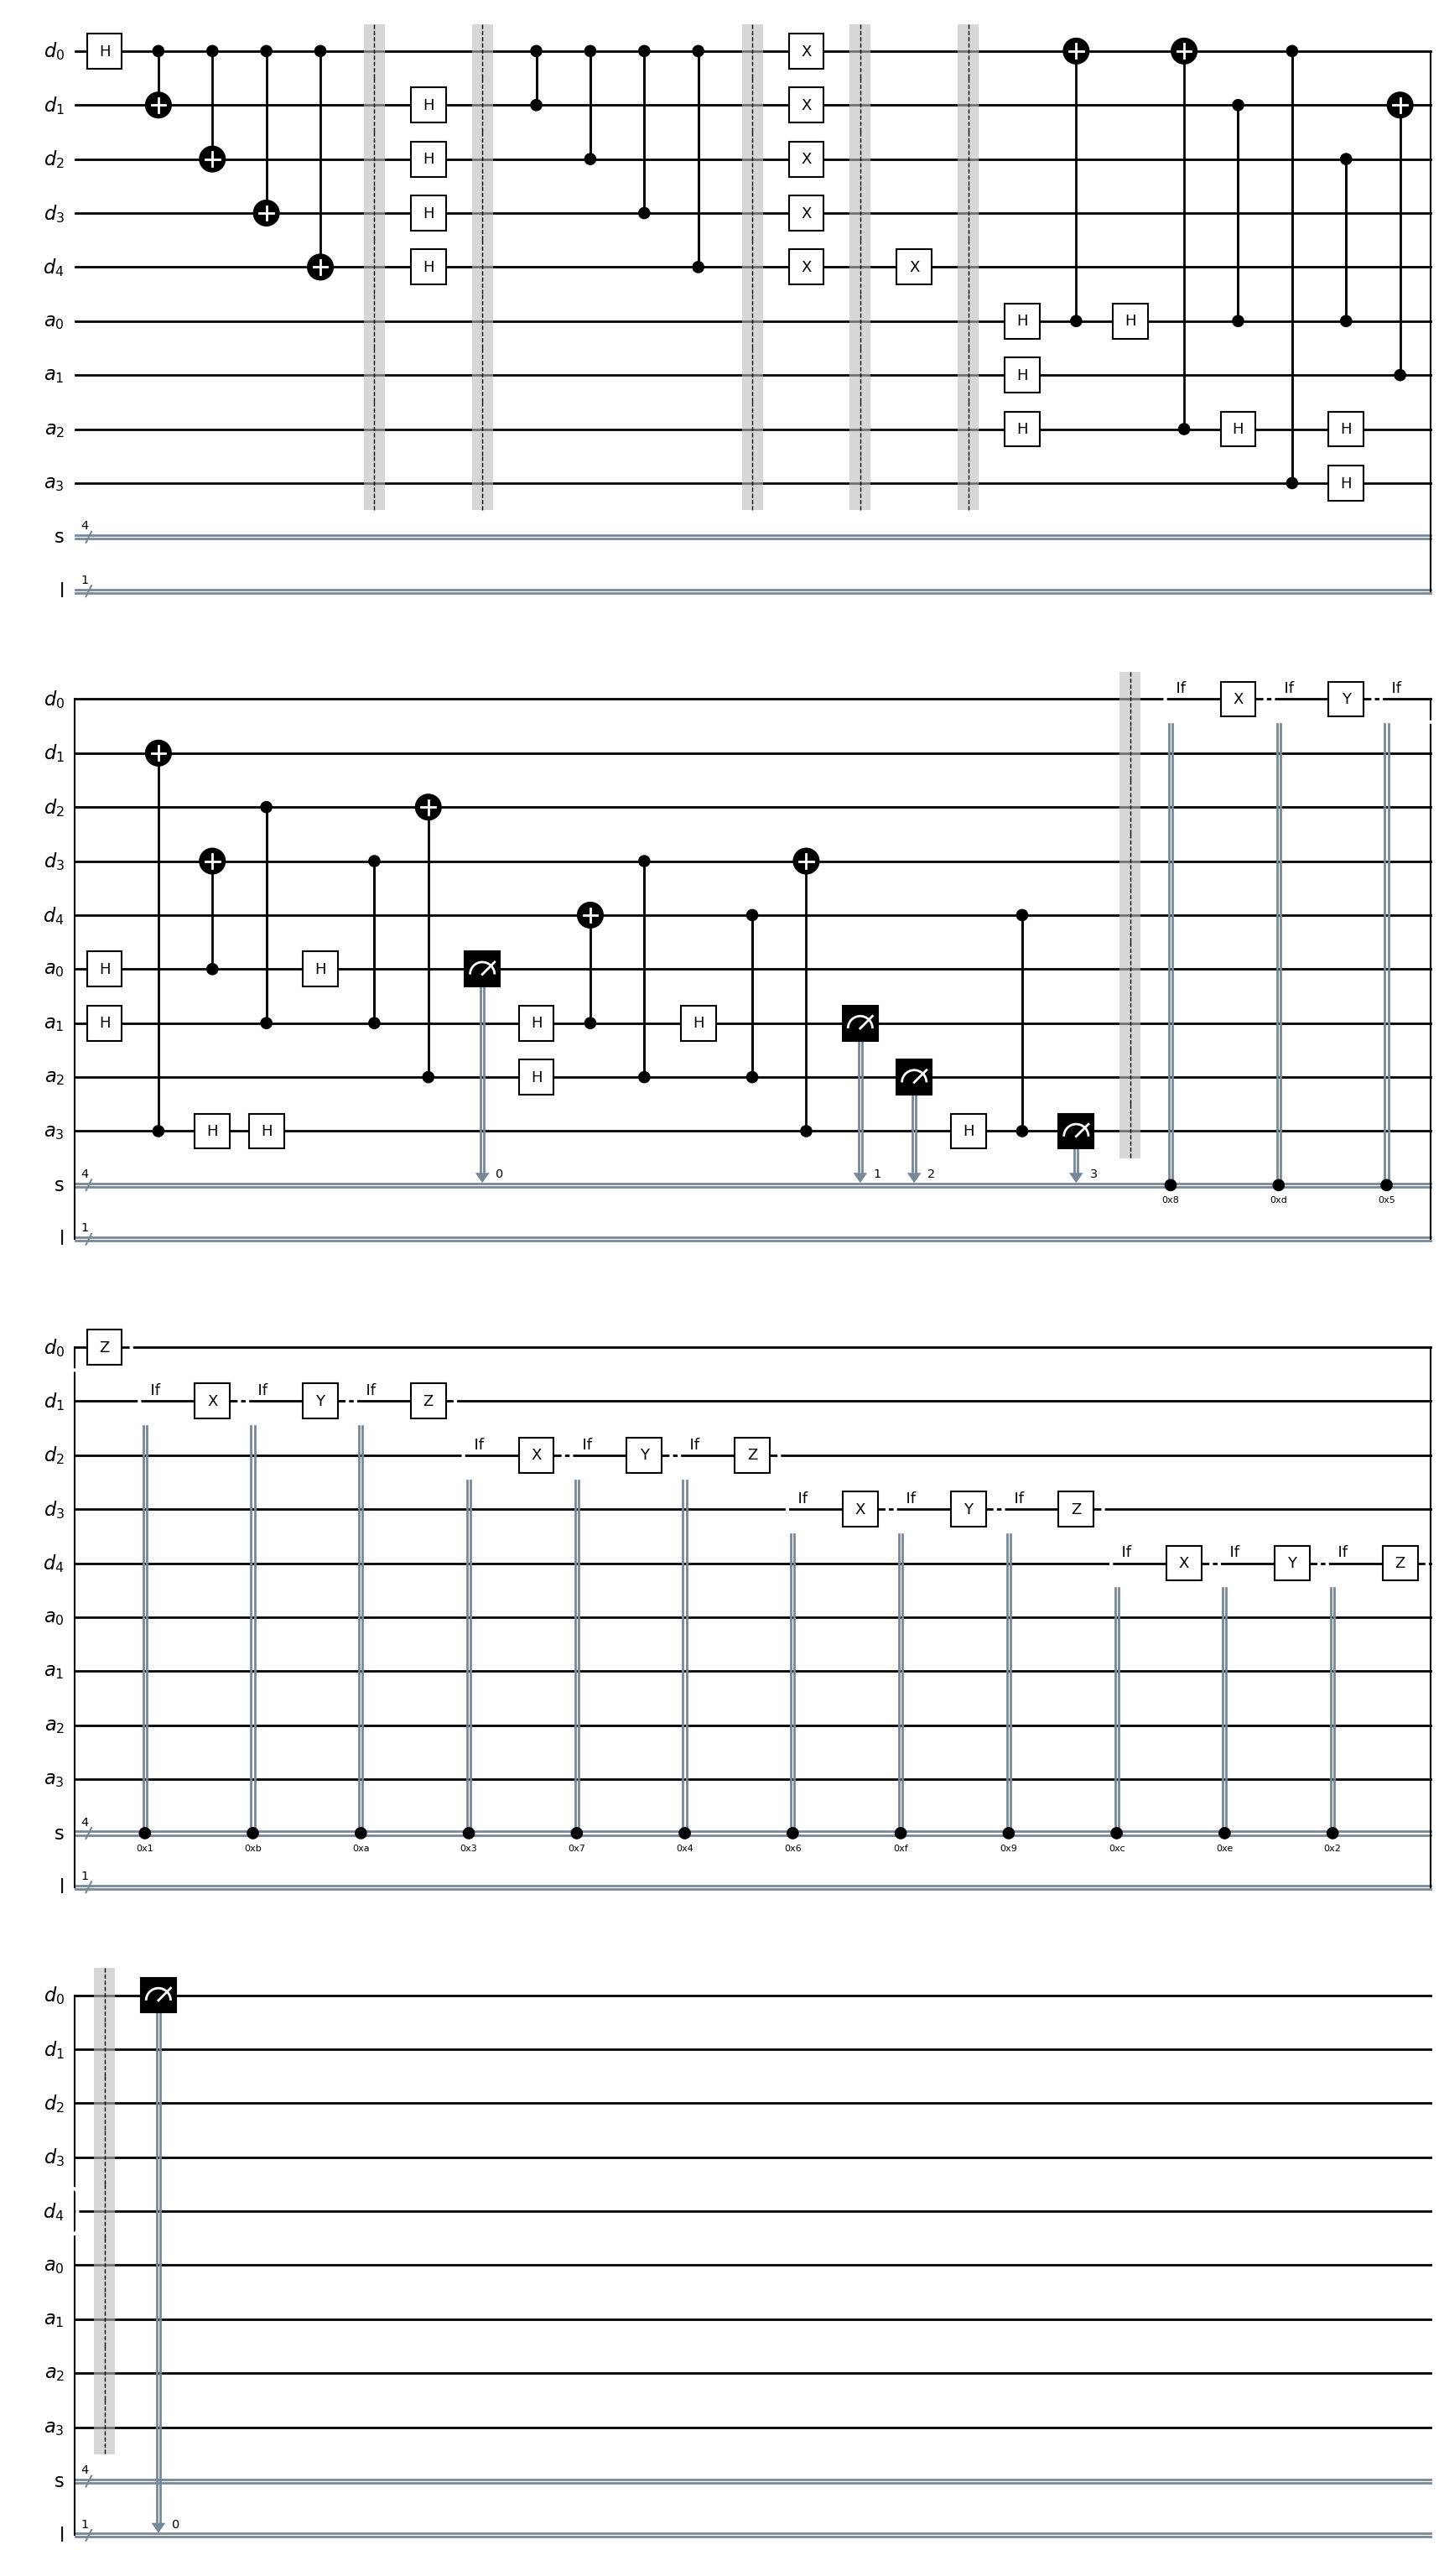

In [179]:
# ── 5‑qubit perfect‑code stabilizers ──────────────────────────
stabilizers = [
    ['X', 'Z', 'Z', 'X', 'I'],
    ['I', 'X', 'Z', 'Z', 'X'],
    ['X', 'I', 'X', 'Z', 'Z'],
    ['Z', 'X', 'I', 'X', 'Z'],
]

# ── Syndrome corrections ─────────
corrections = {
    '0000': None,
    '0001': (0, 'X'), '1011': (0, 'Y'), '1010': (0, 'Z'),
    '1000': (1, 'X'), '1101': (1, 'Y'), '0101': (1, 'Z'),
    '1100': (2, 'X'), '1110': (2, 'Y'), '0010': (2, 'Z'),
    '0110': (3, 'X'), '1111': (3, 'Y'), '1001': (3, 'Z'),
    '0011': (4, 'X'), '0111': (4, 'Y'), '0100': (4, 'Z'),
}

# ── Stabilizer‑measurement sub‑circuit ───────────────────────
def measure_syndromes(qc, data, anc, syn):
    for i, stab in enumerate(stabilizers):
        for j, op in enumerate(stab):
            if op == 'I':
                continue
            if op == 'X':
                qc.h(anc[i]);  qc.cx(anc[i], data[j]);  qc.h(anc[i])
            else:               # 'Z'
                qc.cz(anc[i], data[j])
        qc.measure(anc[i], syn[i])
    return qc

# ── Full QEC circuit, with conditional feed‑forward shown ────
def build_5qubit_qec(apply_x=True, p=0.1):
    d   = QuantumRegister(5, 'd')   # data qubits
    a   = QuantumRegister(4, 'a')   # ancillas
    s   = ClassicalRegister(4, 's') # 4‑bit syndrome
    out = ClassicalRegister(1, 'l') # logical read‑out
    qc  = QuantumCircuit(d, a, s, out, name='5‑qubit QEC')

    # 1. Encode |0〉ₗ
    qc.h(d[0]);  [qc.cx(d[0], d[i]) for i in range(1, 5)]
    qc.barrier();  [qc.h(d[i]) for i in range(1, 5)]
    qc.barrier();  [qc.cz(d[0], d[i]) for i in range(1, 5)]
    qc.barrier()

    # Optional global X (demo)
    if apply_x:
        [qc.x(q) for q in d]
    qc.barrier()

    # 2. Inject random single‑qubit noise
    for q in d:
        if random.random() < p:
            getattr(qc, random.choice(['x', 'y', 'z']))(q)
    qc.barrier()

    # 3. Measure stabilizers
    measure_syndromes(qc, d, a, s)
    qc.barrier()

    # 4. **Feed‑forward corrections** (shown via if_test)
    for syn_bits, corr in corrections.items():
        if corr is None:
            continue
        dq, pauli = corr
        cond_val  = int(syn_bits[::-1], 2)  

        # Anything inside this block runs only if (s == cond_val)
        with qc.if_test((s, cond_val)):
            getattr(qc, pauli.lower())(d[dq])
    qc.barrier()

    # 5. Logical read‑out
    qc.measure(d[0], out[0])
    return qc

# ── Build and draw the circuit ────────────────────────────────
qc = build_5qubit_qec(apply_x=True, p=0.1)
qc.draw('mpl', style="bw")      
